# setup

In [1]:
import os
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely import wkt
from shapely.geometry import Point, Polygon
from pyproj import Transformer
import pickle
import h3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [1]:
waerme_gdf=gpd.read_file("waerme.geojson")
pv_gdf=gpd.read_file("pv.geojson")
nexiga=gpd.read_file("nexiga.geojson")

#### Cluster data in h3

RES = 7

def add_h3(df):
    df = df.copy()
    df["h3"] = None
    valid = df["geometry"].notnull()
    df.loc[valid, "h3"] = df.loc[valid, "geometry"].apply(lambda g: h3.latlng_to_cell(g.y, g.x, RES))
    return df

waerme_gdf = add_h3(waerme_gdf)
pv_gdf = add_h3(pv_gdf)
nexiga = add_h3(nexiga)
demographic_cloumns = nexiga.columns


print("aggregating h3 cells")
# Heat pumps per hex
waerme_agg = waerme_gdf.groupby("h3").agg(heatpump_count=("geometry", "count"), avg_power=("Leistung", "mean"))

# PV systems per hex
pv_agg = pv_gdf.groupby("h3").agg(pv_count=("geometry", "count"), avg_peak=("kWp", "mean"))

# Demographic values per hex
nexiga_agg = nexiga.groupby("h3").agg(income_category=("kk_kat", "median"), pro_ev_attitude=("lceemob", "mean"))

merged = nexiga_agg.join(waerme_agg, how="left").join(pv_agg, how="left").fillna(0)
merged = merged.reset_index()

waerme_gdf.reset_index()
nexiga.reset_index()


nexiga_waerme_join_h3 = nexiga.join(waerme_gdf, lsuffix="_waerme", how="left")

all_data_joined_on_h3 = nexiga.join(waerme_gdf, lsuffix="_waerme", how="left").join(pv_gdf, lsuffix="_pv", how="left")


#nexiga_waerme_join_h3 = nexiga.set_index("h3").join(waerme_gdf.set_index("h3"), on="h3")
waerme_grouped_income = nexiga_waerme_join_h3.groupby("kk_kat").agg(heatpump_count=("geometry", "count"))
waerme_grouped_income.reset_index()

merged["geometry"] = merged["h3"].apply(lambda h: Polygon(h3.cell_to_boundary(h)))

pv_gdf = gpd.GeoDataFrame(merged, geometry="geometry", crs="EPSG:4326")
pv_gdf.to_file("h3.geojson", driver="GeoJSON")

kk_kat_totals = nexiga["kk_kat"].value_counts().sort_index()
waerme_grouped_income["kk_kat_total"] = waerme_grouped_income.index.map(kk_kat_totals)
waerme_grouped_income["rate_per_kk_kat"] = (
    waerme_grouped_income["heatpump_count"] / waerme_grouped_income["kk_kat_total"]
)

NameError: name 'gpd' is not defined

In [3]:
df = all_data_joined_on_h3.copy()
display(df)
for a in df.columns.tolist():
    print(a)
print(len(set(df["h3"])))

,_uid_,id_waerme,v_lfd,v_dat_adm,v_dat_post,kgs44,his,kgs36,kgs22,ags,...,Station oder Maschennetz,Umspannwerke (versorgend),HS/MS-Trafos (versorgend),Abgänge (versorgend),Umspannwerke (anstehend),HS/MS-Trafos (anstehend),Abgänge (anstehend),Info zur Ermittlung,geometry,h3
0,1.0,199251.0,58.0,2101001,2103060,083151097925201529706816710000078,15746487.0,08315109000007,08315109022501,08315109,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86628 48.03862),841f81dffffffff
1,2.0,29.0,58.0,2101001,2103060,0831507679395010981149429100024313,224226341.0,08315076000243,08315076005302,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86943 48.04292),841f81dffffffff
2,3.0,60.0,58.0,2101001,2103060,0831507679395010981068083100002134,20338030.0,08315076000021,08315076005303,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86964 48.04279),841f81dffffffff
3,4.0,100.0,58.0,2101001,2103060,0831507679395010981068083100002136A,25660174.0,08315076000021,08315076005303,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86938 48.04296),841f81dffffffff
4,5.0,102.0,58.0,2101001,2103060,0831507679395010981068095500013046,227046197.0,08315076000130,08315076005303,08315076,...,None,None,None,None,None,None,None,:netzname_ambiguous,POINT (7.86969 48.04315),841f81dffffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75906,75907.0,45335.0,58.0,2101001,2103060,0831504879258006136067969600001233,6780703.0,08315048000012,08315048004901,08315048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
75907,75908.0,15855.0,62.0,2201001,2203060,0831507479379010683068055440008924,19961923.0,08315074400089,08315074005103,08315074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
75908,75909.0,48610.0,58.0,2101001,2103060,083150157920600199106786620000277,2880957.0,08315015000027,08315015020402,08315015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
75909,75910.0,13568.0,62.0,2201001,2203060,083150747937901068306806134003655,21531575.0,08315074400365,08315074005112,08315074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


_uid_
id_waerme
v_lfd
v_dat_adm
v_dat_post
kgs44
his
kgs36
kgs22
ags
kgs22_name
kgs8_name
plz
mplz
po_name
pot_name
str_name
hnr
hnr_zs
hnr_kompl
hnr_typ
lcew
lchh
kk_mio
kk_kat
dskz
kk_idx
lcgchar
lcbjkl
lcschicht
lcalter
lckumw
lckpre
lckneu
lcewb
lcewewa
lceemob
nx_x_etrsu
nx_y_etrsu
nx_kenn
geometry_waerme
h3_waerme
id
Typ
Eigentum_pv
Unnamed: 3
Einbaudatum_pv
Gemeinde_pv
Straßenname
Hausnummer_pv
Kundenkennzeichen
Kundenname
Leistung
Status_pv
Zähleranlage
Zähleranlage Datum
Heizstab vorhanden?
Heizstab Leistung
BP Position
ÜP Position
NS-HA-Fremdverteilung
NS-HA-Kasten
Station
NS-Sonderverbraucher
key
Position_pv
geometry_pv
h3_pv
Datenbestand
Tabelle
ID
Gemeinde
Straße
Hausnummer
Gewinnung
Betriebsspannung [kV]
vereinbarte Anschlusswirkleistung [kW]
kWp
Einbaudatum
Eigentum
Status
Bemerkung
Position
NS Strecke
Station oder Maschennetz
Umspannwerke (versorgend)
HS/MS-Trafos (versorgend)
Abgänge (versorgend)
Umspannwerke (anstehend)
HS/MS-Trafos (anstehend)
Abgänge (anstehend)
Inf

In [4]:
#demographic_cloumns =     #Hier nach Baujahr des Hauses und evtl. andere relevante Parameter angeben

demographic_columns = [a for a in demographic_cloumns if a not in [
    "geometry", "_uid_", "his", "kgs22_name", "kgs8_name", "h3", "plz", "mplz"
    ] + 
"""V_LFD
V_DAT_POST
KGS44
HIS
KGS36
KGS22
KGS22_NAME
KGS8_NAME
PLZ
MPLZ
PO_NAME
POT_NAME
STR_NAME
HNR
HNR_ZS
HNR_KOMPL
HNR_TYP
HNR_TYP""".lower().split("\n")
    ]
print(demographic_columns)
print(df[demographic_columns])

['id', 'v_dat_adm', 'ags', 'lcew', 'lchh', 'kk_mio', 'kk_kat', 'dskz', 'kk_idx', 'lcgchar', 'lcbjkl', 'lcschicht', 'lcalter', 'lckumw', 'lckpre', 'lckneu', 'lcewb', 'lcewewa', 'lceemob', 'nx_x_etrsu', 'nx_y_etrsu', 'nx_kenn']
                id v_dat_adm       ags  lcew  lchh    kk_mio  kk_kat  dskz  \
0       67000644.0   2101001  08315109   4.0   2.0  2.284643     7.0   0.0   
1       71638843.0   2101001  08315076   2.0   1.0  1.026705     6.0   0.0   
2      108777038.0   2101001  08315076   0.0   0.0  6.346322     6.0   0.0   
3      107339344.0   2101001  08315076   2.0   1.0  6.346322     6.0   0.0   
4       56805443.0   2101001  08315076   0.0   0.0  4.177462     6.0   0.0   
...            ...       ...       ...   ...   ...       ...     ...   ...   
75906          NaN   2101001  08315048   7.0   3.0  3.049309     4.0   0.0   
75907          NaN   2201001  08315074  59.0  37.0  7.429903     5.0   0.0   
75908          NaN   2101001  08315015   3.0   1.0  1.054182     4.0   0

In [5]:
df = all_data_joined_on_h3.copy()
df["Einbaujahr"] = df["Einbaudatum"].apply(lambda x : x.year)
df = df.dropna(subset=["h3", "Einbaujahr"])
df_counts = df[[
    "h3", 
    "Einbaujahr",    
    ] + demographic_columns].groupby(by=["h3", "Einbaujahr"]).count()["v_dat_adm"].reset_index().rename(columns={"v_dat_adm":"N_PVs"})
df_means = df[[
    "h3", 
    "Einbaujahr",    
    ] + [a for a in demographic_columns if a != "v_dat_adm" and a in df.select_dtypes(include=np.number).columns.tolist()]].groupby(by=["h3", "Einbaujahr"]).mean().reset_index()

print(len(set(df["h3"])) * len(set(df["Einbaujahr"])))


outlist = [ (i, j)
    for i in set(df.h3)
    for j in set(df.Einbaujahr)]
newdf = pd.DataFrame(data=outlist, columns=['h3','Einbaujahr'])
df_cross = pd.merge(newdf, df_counts, how = "left", on= ["h3", "Einbaujahr"]).fillna(0)
df_cross = pd.merge(df_cross, df_means, how = "left", on= ["h3", "Einbaujahr"])

display(df_cross)

160


,h3,Einbaujahr,N_PVs,id,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,...,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn
0,841f815ffffffff,1925.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,841f815ffffffff,1960.0,2.0,5.427391e+07,3.500000,1.500000,0.713930,5.000000,0.500000,100.238622,...,3.500000,4.000000,5.000000,3.500000,24000.000000,72.500000,2.000000,398596.275000,5.318673e+06,6.000000
2,841f815ffffffff,1969.0,1.0,NaN,2.000000,1.000000,2.289301,7.000000,0.000000,117.642091,...,3.000000,3.000000,5.000000,1.000000,12000.000000,43.000000,8.000000,402758.076000,5.308503e+06,6.000000
3,841f815ffffffff,1970.0,1.0,5.427410e+07,2.000000,1.000000,2.054128,6.000000,0.000000,112.786981,...,3.000000,6.000000,9.000000,1.000000,17000.000000,63.000000,7.000000,399994.006000,5.314667e+06,6.000000
4,841f815ffffffff,1972.0,1.0,NaN,2.000000,1.000000,1.026705,6.000000,0.000000,105.520161,...,4.000000,5.000000,3.000000,1.000000,17000.000000,80.000000,5.000000,393100.513000,5.297216e+06,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,841f83bffffffff,2020.0,29.0,6.168358e+07,3.206897,1.448276,3.134089,5.793103,0.034483,108.038231,...,3.896552,5.655172,3.758621,3.068966,20034.482759,60.620690,4.965517,404956.945759,5.311743e+06,6.965517
156,841f83bffffffff,2021.0,1.0,NaN,7.000000,4.000000,1.626971,4.000000,0.000000,94.511611,...,4.000000,6.000000,4.000000,2.000000,34000.000000,50.000000,7.000000,411157.322000,5.315881e+06,6.000000
157,841f83bffffffff,2022.0,6.0,5.426528e+07,3.166667,1.500000,2.937096,5.166667,0.000000,103.393880,...,3.333333,5.333333,5.333333,2.333333,21166.666667,59.000000,5.500000,411026.373500,5.304175e+06,6.000000
158,841f83bffffffff,2023.0,180.0,5.825382e+07,3.911111,1.750000,2.580316,5.266667,0.022222,103.218522,...,3.272222,4.833333,4.788889,3.172222,21188.888889,52.650000,4.666667,406339.549283,5.307329e+06,7.066667


In [ ]:
from sklearn.model_selection import train_test_split
# Load data.
train_x,train_y, test_x, test_y= train_test_split(df_cross.drop(columns=["N_PVs"]), df_cross["N_PVs"], test_size=0.33, random_state=42)
re_df = pd.DataFrame()
for c in df_cross.columns:
    dfp = df_cross.pivot(index='h3', columns='Einbaujahr', values=c)#.reset_index()
    dfp.columns.names = ['']
    dfp.index.name = None
    #display(dfp)
    c_df = pd.DataFrame()
    for l in dfp.values.tolist()[1:]:
        c_df = pd.concat([c_df, pd.DataFrame({c :[l]})], ignore_index=True, axis =0)
    #display(c_df)
    re_df = pd.concat([re_df, c_df],axis =1)
    #for 
display(re_df)

,h3,Einbaujahr,N_PVs,id,lcew,lchh,kk_mio,kk_kat,dskz,kk_idx,...,lcalter,lckumw,lckpre,lckneu,lcewb,lcewewa,lceemob,nx_x_etrsu,nx_y_etrsu,nx_kenn
0,"[841f815ffffffff, 841f815ffffffff, 841f815ffff...","[1925.0, 1960.0, 1969.0, 1970.0, 1972.0, 1983....","[0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 54273905.5, nan, 54274102.0, nan, 542554...","[nan, 3.5, 2.0, 2.0, 2.0, 14.0, 4.0, 5.0, 0.0,...","[nan, 1.5, 1.0, 1.0, 1.0, 12.0, 2.0, 2.0, 0.0,...","[nan, 0.713929821, 2.2893013858, 2.0541278233,...","[nan, 5.0, 7.0, 6.0, 6.0, 6.0, 7.0, 5.0, 7.0, ...","[nan, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, 100.2386219649, 117.642090701, 112.78698...",...,"[nan, 3.5, 3.0, 3.0, 4.0, 5.0, 2.0, 2.0, 0.0, ...","[nan, 4.0, 3.0, 6.0, 5.0, 9.0, 1.0, 2.0, 0.0, ...","[nan, 5.0, 5.0, 9.0, 3.0, 5.0, 9.0, 9.0, 0.0, ...","[nan, 3.5, 1.0, 1.0, 1.0, 8.0, 5.0, 4.0, 0.0, ...","[nan, 24000.0, 12000.0, 17000.0, 17000.0, 1160...","[nan, 72.5, 43.0, 63.0, 80.0, 40.0, 67.0, 46.0...","[nan, 2.0, 8.0, 7.0, 5.0, 1.0, 8.0, 3.0, 0.0, ...","[nan, 398596.275, 402758.076, 399994.006, 3931...","[nan, 5318672.5045, 5308503.164, 5314666.977, ...","[nan, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 20.0, 10.0..."
1,"[841f81dffffffff, 841f81dffffffff, 841f81dffff...","[1925.0, 1960.0, 1969.0, 1970.0, 1972.0, 1983....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,"[841f83bffffffff, 841f83bffffffff, 841f83bffff...","[1925.0, 1960.0, 1969.0, 1970.0, 1972.0, 1983....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.1170018443, nan, nan, nan, nan, nan, nan, n...","[3.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[77.6006839076, nan, nan, nan, nan, nan, nan, ...",...,"[4.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[9.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[4.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14000.0, nan, nan, nan, nan, nan, nan, nan, n...","[74.0, nan, nan, nan, nan, nan, nan, nan, nan,...","[2.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[412318.971, nan, nan, nan, nan, nan, nan, nan...","[5315485.85, nan, nan, nan, nan, nan, nan, nan...","[6.0, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [48]:
from sklearn.model_selection import train_test_split
# Load data.
dft = df_cross.set_index(["h3", "Einbaujahr"])
dft = dft.drop(columns=["id"])
print(dft)
train_x,test_x, train_y, test_y= train_test_split(dft.drop(columns=["N_PVs"]), dft["N_PVs"], test_size=0.33, random_state=42)
#print(train_x)


                            N_PVs      lcew      lchh    kk_mio    kk_kat  \
h3              Einbaujahr                                                  
841f815ffffffff 1925.0        0.0       NaN       NaN       NaN       NaN   
                1960.0        2.0  3.500000  1.500000  0.713930  5.000000   
                1969.0        1.0  2.000000  1.000000  2.289301  7.000000   
                1970.0        1.0  2.000000  1.000000  2.054128  6.000000   
                1972.0        1.0  2.000000  1.000000  1.026705  6.000000   
...                           ...       ...       ...       ...       ...   
841f83bffffffff 2020.0       29.0  3.206897  1.448276  3.134089  5.793103   
                2021.0        1.0  7.000000  4.000000  1.626971  4.000000   
                2022.0        6.0  3.166667  1.500000  2.937096  5.166667   
                2023.0      180.0  3.911111  1.750000  2.580316  5.266667   
                2024.0      155.0  3.580645  1.696774  2.963188  5.354839   

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(train_x, train_y)
        #eval_set=[(train_x, train_y), (test_x, test_y)],
        #early_stopping_rounds=50,
       #verbose=False)
_ = plot_importance(reg, height=0.9)

pred_y = reg.predict(test_x)

mse = mean_squared_error(y_true=test_y,
                   y_pred=pred_y)
from sklearn.metrics import f1_score

print(test_y.reset_index()["N_PVs"])
print(pred_y)
f1 = f1_score(test_y.reset_index()["N_PVs"].tolist(), pred_y.astype(int))
print(mse)
print(f1)


SyntaxError: unmatched ')' (1233371805.py, line 26)

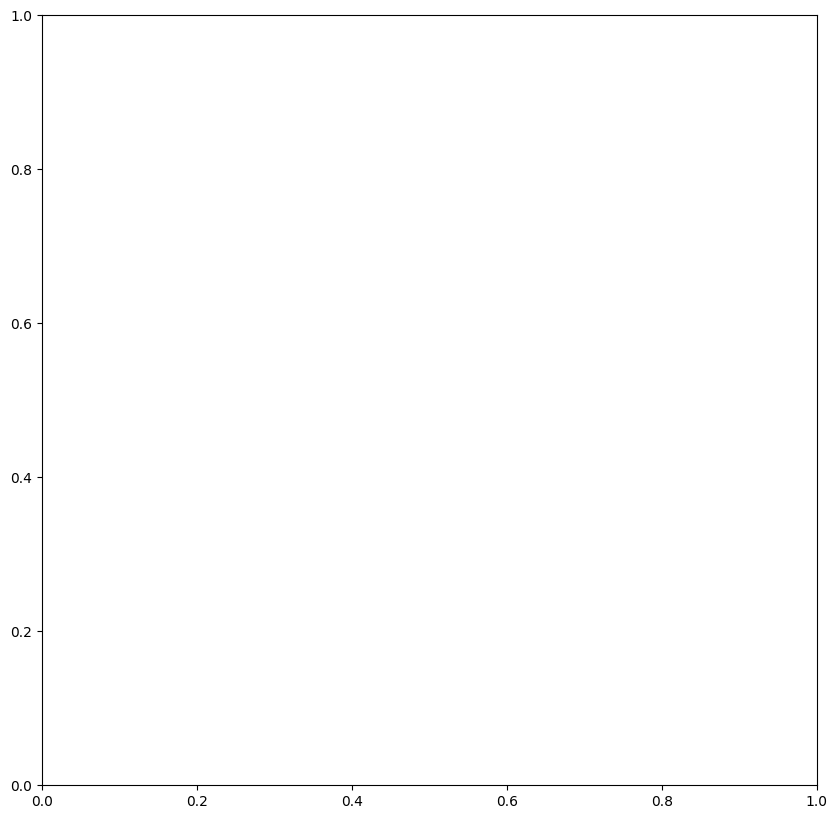

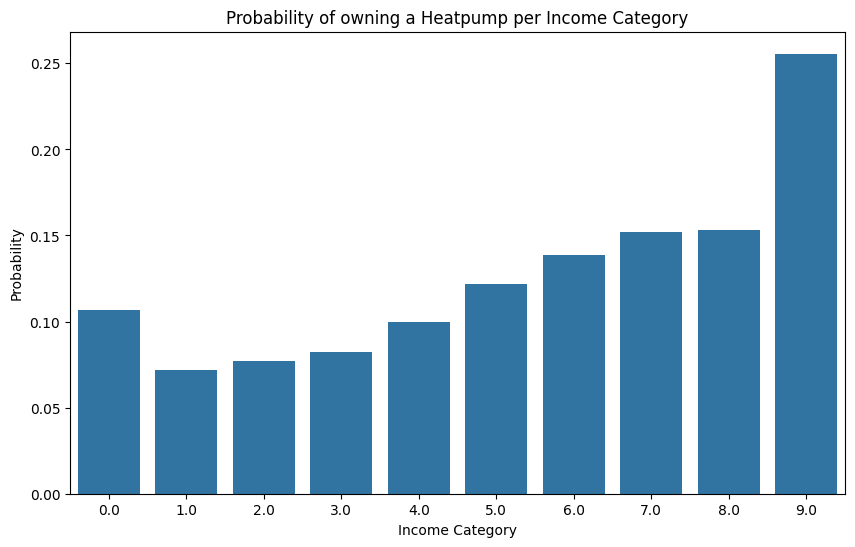

ValueError: Could not interpret value `pv_count` for `y`. An entry with this name does not appear in `data`.

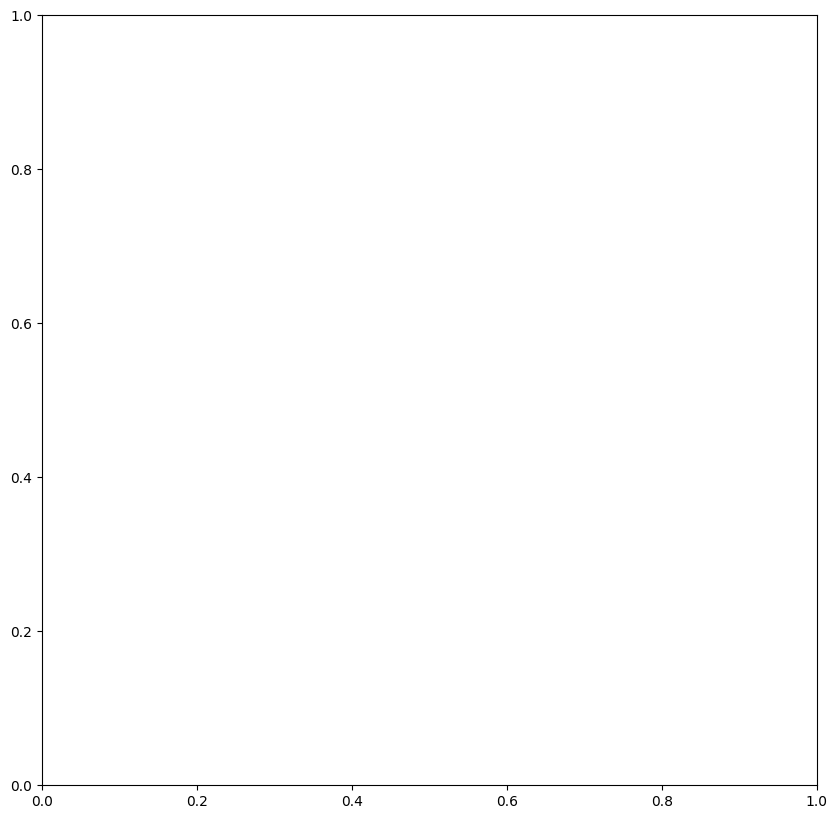

<Figure size 1000x600 with 0 Axes>

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=waerme_grouped_income, x="kk_kat", y="rate_per_kk_kat")
plt.title('Probability of owning a Heatpump per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Probability')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=waerme_grouped_income, x="kk_kat", y="pv_count")
plt.title('PV installations per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Number of PV installs')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=waerme_grouped_income, x="kk_kat", y="heatpump_count")
plt.title('Heat pumps per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Number of Heat pumps')
plt.show()

plt.figure(figsize=(10, 6)) # Create a new figure for clarity
sns.barplot(data=all_data_joined_on_h3.groupby("kk_kat").agg(pv_count=("geometry", "count")).reset_index(), x="kk_kat", y="pv_count")
plt.title('pv per Income Category')
plt.xlabel('Income Category')
plt.ylabel('Number of pv')
plt.show()